(1, 50, 99, 97)
[[-1.45365809 -0.50067588  0.64669684 ...,  1.74613913  1.66981488
   1.57921834]
 [-0.11894975  0.47651994  0.18664089 ...,  1.77075254  1.66436446
   1.5285614 ]
 [ 3.27728418  2.89440714  1.28837058 ...,  1.78972153  1.64860045
   1.47373472]
 ..., 
 [ 2.00104793  2.70463731  2.45753842 ...,  2.1553507   1.18007065
  -0.49283844]
 [ 1.99134256  2.73303114  2.31263429 ...,  2.12185118  1.84492638
   0.35519563]
 [ 1.97226084  1.99553328  1.9620141  ...,  0.75646555  1.75501344
   1.50077906]]


/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


<function matplotlib.pyplot.show(*args, **kw)>

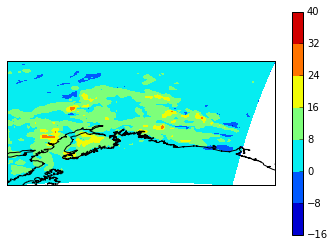

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm
import netCDF4

#WRFOUT_FILE_PATH = 'wrfout_d01_2017-09-11_06:00:00' # Florida
WRFOUT_FILE_PATH ='wrfout_d01_2018-08-13_00:00:00' #Alaska

dataset = netCDF4.Dataset(WRFOUT_FILE_PATH, 'r')

# Get the 2D arrays of lats and lons, corresponding to 
# each data grid point
# Recall that dimensions ar (Time, south_north, west_east)

XLAT = dataset.variables['XLAT'][:]
XLON = dataset.variables['XLONG'][:]

#Get the lower left and upper right corner lat and lon
ll_lat = XLAT[0, 0, 0]; ll_lon = XLON[0, 0, 0]
ur_lat = XLAT[0, -1, -1]; ur_lon = XLON[0, -1, -1]



def destagger_uv(ustagger=None, vstagger=None):
   
    """
    Creates arrays u and v on grid points rather than their native mass points
    by assigning to each grid point the average of the adjacent mass points

    Assumes ustagger has dimensions (Time, bottom_top, south_north, west_east_stag)
    Assumes vstagger has dimensions (Time, bottom_top, south_north_stag, west_east)

    By averaging, creates U and V arrays of dimensions 
    (Time, bottom_top, south_north, west_east)
    """

    # We can compute the dimensions of the arrays through knowledge of 
    # their shapes
    Time_dim = ustagger.shape[0]
    bottom_top_dim = ustagger.shape[1]
    south_north_dim = ustagger.shape[2]
    west_east_stag_dim = ustagger.shape[3]
    south_north_stag_dim = vstagger.shape[2]
    west_east_dim = vstagger.shape[3]

    # Allocate and shape the arrays that will be returned
    u = v = np.ndarray( (Time_dim, bottom_top_dim, south_north_dim, west_east_dim) )

    # Now the destaggering - each grid point in the destaggered array is
    # the average of the adjacent mass points in the staggered arrays

    for j in np.arange(west_east_dim):
        u[:,:,:,j] = ( ustagger[:,:,:,j] + ustagger[:,:,:,j+1] ) / 2.0
    for i in np.arange(south_north_dim):
        v[:,:,i,:] = ( vstagger[:,:,i,:] + vstagger[:,:,i+1,:] ) / 2.0    

    return u, v

# This is all we need to define a cylindrical map project
the_map = bm.Basemap(projection='cyl',
                    llcrnrlon=ll_lon,
                    llcrnrlat=ll_lat,
                    urcrnrlon=ur_lon,
                    urcrnrlat=ur_lat,
                    resolution= 'i',
                    area_thresh=1000.0)
the_map.drawcoastlines()
U_staggered = dataset.variables['U'][:]
V_staggered = dataset.variables['V'][:]
U, V = destagger_uv(U_staggered, V_staggered)
#Create WS10
WS = (np.sqrt(U**2 + V**2)) *1.94384 #convert the units to knots




#2d map coordinates
map2d_x, map2d_y = the_map(XLON[0,:,:], XLAT[0,:,:])
print(WS.shape)
LLWS = WS[0,1,:,:] - WS[0,0,:,:]
print(LLWS)

the_map.contourf(map2d_x, map2d_y, LLWS[:,:])

plt.colorbar()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

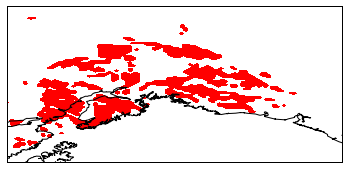

In [26]:
THRESHOLD = 10.0
masked_array = (LLWS > THRESHOLD)

# This is all we need to define a cylindrical map project
the_map = bm.Basemap(projection='cyl',
                    llcrnrlon=ll_lon,
                    llcrnrlat=ll_lat,
                    urcrnrlon=ur_lon,
                    urcrnrlat=ur_lat,
                    resolution= 'i',
                    area_thresh=1000.0)
the_map.drawcoastlines()

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['w','r'])
plt.contourf(map2d_x, map2d_y, masked_array, cmap=cmap)
plt.show